# Understanding Amazon Forest from Space

## Import Libraries

In [4]:
# Importing the necessary libraries
import os
import math

# Data wrangling libraries
import pandas as pd
import numpy as np
import seaborn as sns
import gc 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2 

# model building libraries

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from keras.callbacks import EarlyStopping 
from keras.preprocessing.image import ImageDataGenerator

In [5]:
# path to datasets
path_to_train_data = '../input/planets-dataset/planet/planet/train_classes.csv'
path_to_test_data = '../input/planets-dataset/planet/planet/sample_submission.csv'
path_to_train_image = '../input/planets-dataset/planet/planet/train-jpg/'
path_to_test_image = '../input/planets-dataset/planet/planet/test-jpg/'

In [6]:
# load test and train data
train_df = pd.read_csv(path_to_train_data)
train_df.sample(n=5, random_state=42).T

,34602,11243,14499,18918,30631
image_name,train_34602,train_11243,train_14499,train_18918,train_30631
tags,clear primary road,clear primary water,clear conventional_mine habitation primary roa...,cloudy,agriculture clear cultivation cultivation habi...


In [7]:
df_test = pd.read_csv(path_to_test_data)
df_test.sample(n=5, random_state=42).T

,60679,27520,27416,13664,44093
image_name,file_9538,test_27520,test_27416,test_13664,file_13079
tags,primary clear agriculture road water,primary clear agriculture road water,primary clear agriculture road water,primary clear agriculture road water,primary clear agriculture road water


## EDA

In [8]:
# number of images in the dataset
num_images = train_df.shape[0]
print(f'The dataset contains {num_images} images.')

The dataset contains 40479 images.


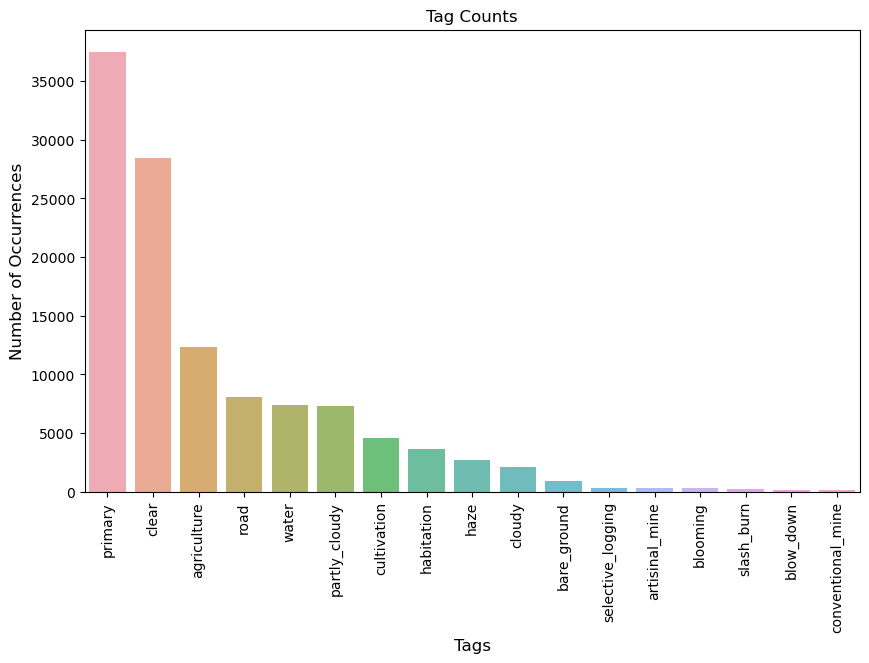

In [9]:
def plot_tag_counts_seaborn(df, column='tags', figsize=(10,6)):
    """
    Plot the counts of tags in a specified column of a DataFrame using seaborn.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The column containing the tags. Default is 'tags'.
    figsize (tuple): The size of the figure to plot. Default is (10,6).
    """
    # Split the tags and flatten the list
    tags = [tag for sublist in df[column].apply(lambda x: x.split(' ')) for tag in sublist]

    # Calculate the counts of each tag
    tag_counts = pd.Series(tags).value_counts()

    # Create a new figure with the specified size
    plt.figure(figsize=figsize)

    # Plot the tag counts using seaborn
    sns.barplot(x=tag_counts.index, y=tag_counts.values, alpha=0.8)
    plt.title('Tag Counts')
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Tags', fontsize=12)
    plt.xticks(rotation=90)

    # Display the figure
    plt.show()

# Call the function
plot_tag_counts_seaborn(train_df)


In [10]:
def plot_images_from_folder(folder, num_images=9, figsize=(20,20)):
    """
    Plot images from a specified folder.

    Parameters:
    folder (str): The location of the dataset.
    num_images (int): The number of images to plot. Default is 9.
    figsize (tuple): The size of the figure to plot. Default is (20,20).
    """
    # Create a new figure with the specified size
    plt.figure(figsize=figsize)

    # Calculate the number of rows and columns
    cols = round(math.sqrt(num_images))
    rows = math.ceil(num_images / cols)

    # Loop over the range of image numbers
    for i in range(num_images):
        # Define the subplot
        plt.subplot(rows, cols, i+1)

        # Define the filename
        filename = f'{folder}/train_{i}.jpg'

        # Load the image pixels
        image = imread(filename)

        # Plot the raw pixel data
        plt.imshow(image)

    # Display the figure
    plt.show()

In [11]:
gc.collect()

5920

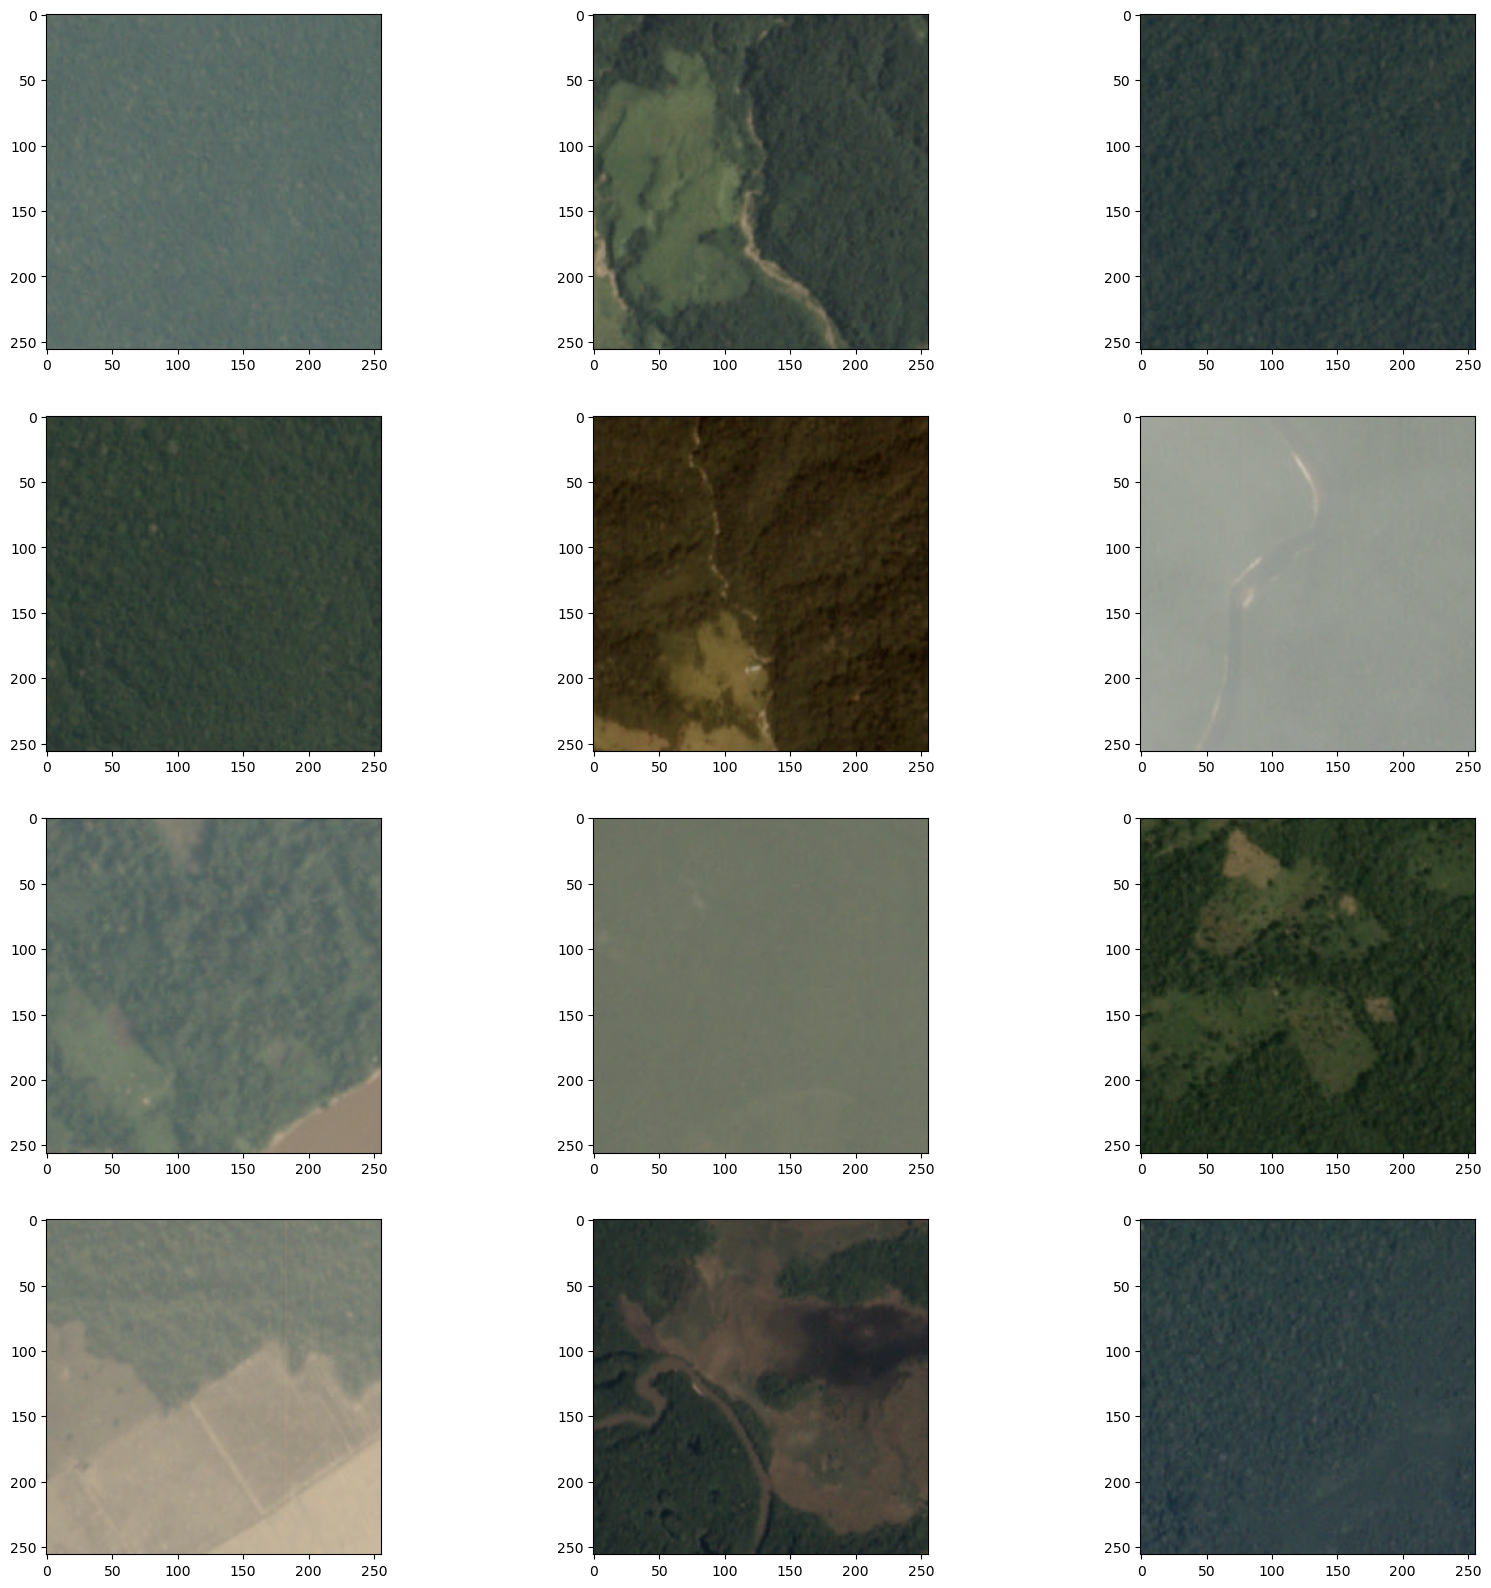

In [12]:
# Call the function to plot 12 images
plot_images_from_folder(path_to_train_image, num_images=12)

# Data Preprocessing

In [13]:
labels = set()
def splitting_tags(tags):
    '''
    Takes in tags column, splits the tags and store as a set
    '''
    [labels.add(tag) for tag in tags.split()]
    
# Create a copy of `train_df`
train_df1 = train_df.copy()
train_df1['tags'].apply(splitting_tags)
labels = list(labels)
print(labels)

['cloudy', 'conventional_mine', 'partly_cloudy', 'clear', 'water', 'habitation', 'cultivation', 'bare_ground', 'blooming', 'road', 'selective_logging', 'agriculture', 'slash_burn', 'haze', 'primary', 'artisinal_mine', 'blow_down']


In [14]:
##One hot encoding is performed on the labels in train classes 
for tag in labels:
    train_df1[tag] = train_df1['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
## adding .jpg extension to the column image_name so as to have same name format as the image files
train_df1['image_name'] = train_df1['image_name'].apply(lambda x: '{}.jpg'.format(x))
train_df1.head()

,image_name,tags,cloudy,conventional_mine,partly_cloudy,clear,water,habitation,cultivation,bare_ground,blooming,road,selective_logging,agriculture,slash_burn,haze,primary,artisinal_mine,blow_down
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,train_1.jpg,agriculture clear primary water,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0
2,train_2.jpg,clear primary,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,train_3.jpg,clear primary,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0


In [15]:
# Define the columns
columns = list(train_df1.columns[2:])
columns

['cloudy',
 'conventional_mine',
 'partly_cloudy',
 'clear',
 'water',
 'habitation',
 'cultivation',
 'bare_ground',
 'blooming',
 'road',
 'selective_logging',
 'agriculture',
 'slash_burn',
 'haze',
 'primary',
 'artisinal_mine',
 'blow_down']

In [ ]:
def process_dataframe(df, labels, image_col='image_name'):
    """
    Perform one-hot encoding on the labels and add .jpg extension to the image names.

    Parameters:
    df (pd.DataFrame): The DataFrame to process.
    labels (list): The labels to one-hot encode.
    image_col (str): The column containing the image names. Default is 'image_name'.
    """
    # One-hot encoding of labels
    for tag in labels:
        df[tag] = df['tags'].apply(lambda x: 1 if tag in x.split() else 0)

    # Add .jpg extension to image names
    df[image_col] = df[image_col].apply(lambda x: f'{x}.jpg')

    return df

def get_columns(df, start_index=2):
    """
    Get a list of column names from a DataFrame starting from a specified index.

    Parameters:
    df (pd.DataFrame): The DataFrame to get the columns from.
    start_index (int): The index to start from. Default is 2.
    """
    # Get the columns
    columns = list(df.columns[start_index:])

    return columns


columns = get_columns(train_df1)
train_df1 = process_dataframe(train_df1, labels)

In [ ]:
gc.collect()

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_data_generators(df, directory, x_col, y_col, batch_size=32, seed=42, target_size=(128,128), validation_split=0.2):
    """
    Create train and validation data generators.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    directory (str): The directory where the images are located.
    x_col (str): The column in the DataFrame that contains the image names.
    y_col (list): The columns in the DataFrame that contain the labels.
    batch_size (int): The batch size. Default is 32.
    seed (int): The random seed. Default is 42.
    target_size (tuple): The target size for the images. Default is (128,128).
    validation_split (float): The fraction of the data to use for validation. Default is 0.2.
    """
    # Initialize ImageDataGenerator with a validation split
    datagen = ImageDataGenerator(rescale=1./255., validation_split=validation_split)

    # Create the train data generator
    train_generator = datagen.flow_from_dataframe(dataframe=df, directory=directory, 
                                                  x_col=x_col, y_col=y_col, subset='training', 
                                                  batch_size=batch_size, seed=seed, shuffle=True, 
                                                  class_mode='raw', target_size=target_size)

    # Create the validation data generator
    val_generator = datagen.flow_from_dataframe(dataframe=df, directory=directory, 
                                                x_col=x_col, y_col=y_col, subset='validation', 
                                                batch_size=batch_size, seed=seed, shuffle=True, 
                                                class_mode='raw', target_size=target_size)

    return train_generator, val_generator

In [17]:
train_generator, val_generator = create_data_generators(train_df1, path_to_train_image, 
                                                        'image_name', columns)

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [18]:
def calculate_step_sizes(train_gen, val_gen):
    """
    Calculate the step sizes for training and validation data.

    Parameters:
    train_gen (ImageDataGenerator): The training data generator.
    val_gen (ImageDataGenerator): The validation data generator.
    """
    # Calculate the step size for training data
    step_train_size = int(np.ceil(train_gen.samples / train_gen.batch_size))

    # Calculate the step size for validation data
    step_val_size = int(np.ceil(val_gen.samples / val_gen.batch_size))

    return step_train_size, step_val_size

In [19]:
step_train_size, step_val_size = calculate_step_sizes(train_generator, val_generator)
step_train_size, step_val_size

(1012, 253)

# Model Building

In [20]:
def create_cnn_model(input_shape=(128, 128, 3), num_classes=17):
    """
    Create a Convolutional Neural Network (CNN) model.

    Parameters:
    input_shape (tuple): The shape of the input images. Default is (128, 128, 3).
    num_classes (int): The number of classes. Default is 17.
    """
    # Initialize the model
    model = Sequential()

    # Add convolution layers
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', 
                     input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Add flatten layer
    model.add(Flatten())

    # Add fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [23]:
# Create the model
model = create_cnn_model()

# Display the model architecture
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 128)     

In [24]:
# define callbacks
earlystop = EarlyStopping(monitor='val_accuracy', 
                          patience=2, verbose=1, 
                          mode='max', 
                          restore_best_weights=True)

In [25]:
# Fit the model 
history = model.fit(x = train_generator, 
                    steps_per_epoch = step_train_size, 
                    validation_data = val_generator,
                    validation_steps = step_val_size,
                    epochs = 20, 
                    callbacks = [earlystop])

Epoch 1/20
1012/1012 [==============================] - 223s 208ms/step - loss: 0.2045 - accuracy: 0.0556 - val_loss: 0.1680 - val_accuracy: 0.0700
Epoch 2/20
1012/1012 [==============================] - 112s 110ms/step - loss: 0.1552 - accuracy: 0.1579 - val_loss: 0.1409 - val_accuracy: 0.1143
Epoch 3/20
1012/1012 [==============================] - 110s 109ms/step - loss: 0.1432 - accuracy: 0.1842 - val_loss: 0.1346 - val_accuracy: 0.1736
Epoch 4/20
1012/1012 [==============================] - 110s 109ms/step - loss: 0.1356 - accuracy: 0.2173 - val_loss: 0.1306 - val_accuracy: 0.1490
Epoch 5/20
1012/1012 [==============================] - 111s 109ms/step - loss: 0.1289 - accuracy: 0.2263 - val_loss: 0.1305 - val_accuracy: 0.1501
Epoch 5: early stopping


In [27]:
gc.collect()

23

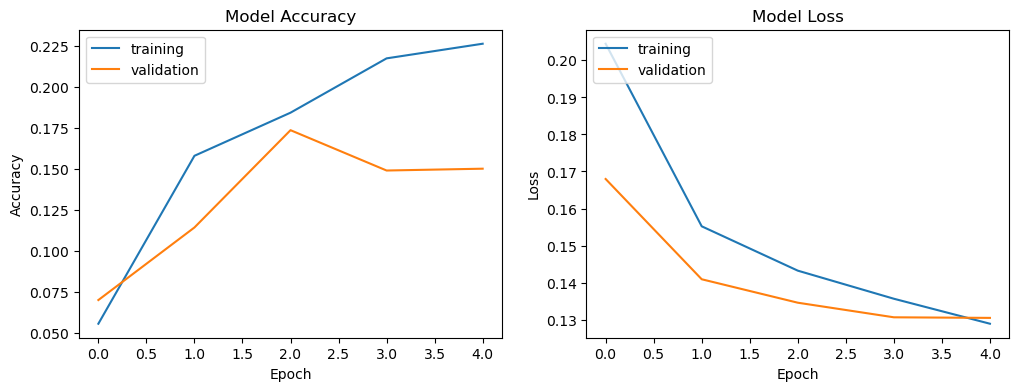

In [30]:
# Define a function to plot the accuracy and loss curves
def show_model_performance(history):
    """
    Display the training and validation accuracy and loss curves.

    Parameters:
    history (History): The history object returned from the fit method of a keras model.
    """
    # Set the figure size
    plt.figure(figsize=(12, 4))

    # Loop over the metrics
    for i, metric in enumerate(['accuracy', 'loss']):
        # Create a subplot
        plt.subplot(1, 2, i + 1)
        # Plot the training and validation values
        plt.plot(history.history[metric])
        plt.plot(history.history['val_' + metric])
        # Add the title and labels
        plt.title(f'Model {metric.capitalize()}')
        plt.ylabel(metric.capitalize())
        plt.xlabel('Epoch')
        plt.legend(['training', 'validation'], loc='upper left')

    # Show the figure
    plt.show()

# Call the function
show_model_performance(history)

In [31]:
gc.collect()

21695

In [34]:
# Create a new model for making predictions
predictor = create_cnn_model()

In [36]:
# Load the sample submission file
sample_submission = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')

# Make a copy of the file
sample_submission1 = sample_submission.copy()

# Add the .jpg extension to the image names
sample_submission1['image_name'] = sample_submission1['image_name'] + '.jpg'

# Display the first five rows
sample_submission1.head()


,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [40]:
# Divide the sample submission file into two splits,
# first test1_df contains the first 40669 images 
test_df1 = sample_submission1.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
test_df1.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [44]:
# Create an imagedatagenerator for the test images with rescaling
test_datagen = ImageDataGenerator(rescale = 1/255)

# Generate the test images from the first test image files dataframe
test_gen = test_datagen.flow_from_dataframe(dataframe=test_df1, 
                                            directory='/kaggle/input/planets-dataset/planet/planet/test-jpg/', 
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=32,
                                            seed=42,
                                            shuffle=False, 
                                            class_mode=None, 
                                            target_size=(128,128))

# Calculate the number of steps for the test generator
step_test_size1 = int(np.ceil(test_gen.samples/test_gen.batch_size))


Found 40669 validated image filenames.


In [45]:
# Reset the test generator to avoid shuffling the images
test_gen.reset()

# Make predictions using the model on the test images
pred = model.predict(test_gen, steps=step_test_size1, verbose=1)


1271/1271 [==============================] - 154s 121ms/step


In [47]:
# Extract the image names from the test generator
file_names = test_gen.filenames

# Create a dataframe from the predicted values
pred_tags = pd.DataFrame(pred)

# Apply a threshold of 0.5 to select the labels for each image
pred_tags = pred_tags.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis = 1)

# Combine the image names and the labels into a result dataframe
result1 = pd.DataFrame({'image_name': file_names, 'tags': pred_tags})
result1.head()


,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,clear primary
4,test_4.jpg,partly_cloudy primary


In [48]:
gc.collect()

77

In [52]:
#second batch of the test dataset
additional_df = sample_submission1.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)
additional_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [57]:
# Generate the test images from the second test image files dataframe
test_gen1 = test_datagen.flow_from_dataframe(dataframe=additional_df, 
                                                directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional', 
                                                x_col='image_name', 
                                                y_col=None, 
                                                batch_size=32, 
                                                shuffle=False, 
                                                class_mode=None, 
                                                target_size=(128,128))

# Calculate the number of steps for the second test generator
step_test_size2 = int(np.ceil(test_gen1.samples/test_gen1.batch_size))


Found 20522 validated image filenames.


In [59]:
#we reset the generator to avoid shuffling, then make prediction on the generator
test_gen1.reset()
pred1 = model.predict(test_gen1, steps = step_test_size2, verbose = 1)

642/642 [==============================] - 128s 200ms/step


In [60]:
#this is to get the filenames in the generator using the attribute .filenames
file_names1 = test_gen1.filenames

#convert the predicted values to a dataframe
#join two labels together if the prob(occurrance of the label) > 0.5
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ''.join(np.array(labels)[x>0.5]), axis = 1)

result2 = pd.DataFrame({'image_name': file_names1, 'tags': pred_tags1})
result2.head()

,image_name,tags
0,file_0.jpg,clearprimary
1,file_1.jpg,clearagricultureprimary
2,file_10.jpg,agricultureprimary
3,file_100.jpg,clearagricultureprimary
4,file_1000.jpg,clearprimary


In [61]:
# Final result of the predicted tags for the test images,
# we need to concat the first and second results in 
#that order to avoid shuffling the index
final_df = pd.concat([result1, result2])

final_df = final_df.reset_index().drop('index', axis =1)

print(final_df.shape)
final_df.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,clear primary
4,test_4.jpg,partly_cloudy primary


In [62]:
final_df['image_name'] = final_df['image_name'].apply(lambda x: x[:-4])
final_df.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear primary
4,test_4,partly_cloudy primary


In [69]:
final_df.to_csv('submission.csv', index = False)